In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [23]:
import os
import sys
parent_directory = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
print("The parent directory is:", parent_directory)
sys.path.append(parent_directory)

from Models import encoder_model, decoder_model, VAE, load_model_vae

The parent directory is: c:\Users\kkosara\ImageAutoEncoder


In [24]:
# import os
import numpy as  np
import matplotlib.pyplot as plt
from PIL import  Image
import pandas
from matplotlib.pyplot import imshow


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape
from tensorflow.keras.models import Model
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import layers

#
# from ..Models import encoder_model, decoder_model, VAE, load_model_vae
from Data import get_image_data
#to reduce the tensorflow messages
# tf.get_logger().setLevel('WARNING')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.get_logger().setLevel('ERROR')

In [25]:
# Sampling layer
class Sampling(layers.Layer):
    "used to sample a vector in latent space with learned mean - z_mean and (log) variance - z_log_var"
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch_size = tf.shape(z_mean)[0]
        vec_len = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch_size, vec_len))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def encoder_model(input_shape, filters, dense_layer_dim, latent_dim):
    # Create input layer
    encoder_layers_dim = []
    encoder_inputs = keras.Input(shape=input_shape)
    encoder_layers_dim.append(tuple(encoder_inputs.shape[1:]))
    # Add convolutional layers with specified number of filters and activation function
    x = layers.Conv2D(filters[0], (3,3), activation="relu", strides=2, padding="same")(encoder_inputs)
    encoder_layers_dim.append(tuple(x.shape[1:]))
    # x = MaxPooling2D((2, 2), padding="same")(x)
    # Add additional convolutional layers with specified number of filters and activation function
    mid_layers = [layers.Conv2D(f, 3, activation="relu", strides=2, padding="same") for f in filters[1:]]
    for mid_layer in mid_layers:
        x = mid_layer(x)
        encoder_layers_dim.append(tuple(x.shape[1:]))
        # x = MaxPooling2D((2, 2), padding="same")(x)
    
    # Flatten convolutional output to prepare for dense layers
    x = layers.Flatten()(x)
    encoder_layers_dim.append(tuple(x.shape[1:]))
    # Add dense layer with specified number of neurons and activation function
    x = layers.Dense(dense_layer_dim, activation='relu')(x)
    
    # Add output layers for latent space (mean and variance) and sample from this space
    z_mean = layers.Dense(latent_dim, name = "z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder_layers_dim.append(tuple(z.shape[1:]))
    
    # Create encoder model
    return keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder'), encoder_layers_dim
# test_encoder, encoder_layers_dim = encoder_model(input_shape = (56,56,1), filters=[32, 64], dense_layer_dim=16, latent_dim=2)
# test_encoder.summary()

# decoder
def decoder_model(encoder_layers_dim):
    latent_dim = encoder_layers_dim[-1][0]
    dense_layer_dim = encoder_layers_dim[-2][0]
    first_conv_layer_dim = encoder_layers_dim[-3]
    filters = [f[-1] for f in encoder_layers_dim[1:-2]]
    output_layer = encoder_layers_dim[0]

    latent_inputs = keras.Input(shape=(latent_dim,))
    # feed latent vector through a dense layer with ReLU activation
    # note that we apply the first filter in the form of dense and reshape it
    x = layers.Dense(dense_layer_dim, activation="relu")(latent_inputs)
    # reshape output from dense layer to match dimensions of first convolutional layer
    x = layers.Reshape(first_conv_layer_dim)(x)
    # apply series of transpose convolutional layers with ReLU activation and same padding and Upsampling
    mid_layers = [layers.Conv2DTranspose(f, 3, activation="relu", strides=2, padding="same") for f in filters[::-1]]
    for mid_layer in mid_layers:
        x = mid_layer(x)
    
    # apply final convolutional layer with sigmoid activation to output reconstructed image
    decoder_outputs = layers.Conv2DTranspose(output_layer[-1], 3, activation="sigmoid", padding="same")(x)
    
    # create and return Keras model with latent vector as input and reconstructed image as output
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")
# test_decoder = decoder_model(encoder_layers_dim)
# test_decoder.summary()


class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    def call(self, x):
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, z, reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            # z_mean, z_log_var, z = self.encoder(data)
            # reconstruction = self.decoder(z)
            z_mean, z_log_var, z, reconstruction = self(data)
            # reconstruction_loss = tf.reduce_mean(
            #     tf.reduce_sum(
            #         keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
            #     )
            # )
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(data, reconstruction), axis = (1, 2)))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [33]:
DATA_DIR =  [r'C:\Users\kkosara\ImageAutoEncoder\Data'] #[r'C:\Users\kkosara\AutoDRIVE-Nigel-Dataset\data'] Data\test1
OUTPUT_IMAGE_SHAPE = 56
INPUT_SHAPE = (OUTPUT_IMAGE_SHAPE, OUTPUT_IMAGE_SHAPE, 1)
FILTERS = [32, 64]
NUM_CONV_LAYERS = len(FILTERS)
DENSE_LAYER_DIM = 16
LATENT_DIM = 10
BETA = 1.0
BATCH_SIZE = 128
AUTOTUNE = tf.data.AUTOTUNE
LEARNING_RATE = 1e-4
PATIENCE = 10
EPOCHS  = 2
TRAIN_SPLIT = 0.8
LOGDIR = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
GRAYSCALE = True

all_image_paths = get_image_data(DATA_DIR)
image_count = len(all_image_paths)

# Create a dataset from the list of image file paths
dataset = tf.data.Dataset.from_tensor_slices(all_image_paths)

dataset

C:\Users\kkosara\ImageAutoEncoder\Data
Total number of imges: 55


<TensorSliceDataset shapes: (), types: tf.string>

In [34]:
for item in dataset:
    print(item)

tf.Tensor(b'C:\\Users\\kkosara\\ImageAutoEncoder\\Data\\test1\\Camera0_Frame_2023_04_02_18_33_06_687.jpg', shape=(), dtype=string)
tf.Tensor(b'C:\\Users\\kkosara\\ImageAutoEncoder\\Data\\test1\\Camera0_Frame_2023_04_02_18_33_06_736.jpg', shape=(), dtype=string)
tf.Tensor(b'C:\\Users\\kkosara\\ImageAutoEncoder\\Data\\test1\\Camera0_Frame_2023_04_02_18_33_06_780.jpg', shape=(), dtype=string)
tf.Tensor(b'C:\\Users\\kkosara\\ImageAutoEncoder\\Data\\test1\\Camera0_Frame_2023_04_02_18_33_06_823.jpg', shape=(), dtype=string)
tf.Tensor(b'C:\\Users\\kkosara\\ImageAutoEncoder\\Data\\test1\\Camera0_Frame_2023_04_02_18_33_06_865.jpg', shape=(), dtype=string)
tf.Tensor(b'C:\\Users\\kkosara\\ImageAutoEncoder\\Data\\test1\\Camera0_Frame_2023_04_02_18_33_06_907.jpg', shape=(), dtype=string)
tf.Tensor(b'C:\\Users\\kkosara\\ImageAutoEncoder\\Data\\test1\\Camera0_Frame_2023_04_02_18_33_06_952.jpg', shape=(), dtype=string)
tf.Tensor(b'C:\\Users\\kkosara\\ImageAutoEncoder\\Data\\test1\\Camera0_Frame_2023_0

In [35]:
# Shuffle the dataset with a buffer size of 1000 and seed of 42
dataset = dataset.shuffle(buffer_size=1000, seed=42, reshuffle_each_iteration=False)

# Load and preprocess the images
# Function to load and preprocess an image
def load_and_preprocess_image(path=all_image_paths, shape=OUTPUT_IMAGE_SHAPE, grayscale=GRAYSCALE):
    # Load the image file
    image = tf.io.read_file(path)
    # # Decode the image to a tensor
    image = tf.image.decode_jpeg(image, channels=3)
    # if grayscale:
        # Convert RGB to grayscale
    image = tf.image.rgb_to_grayscale(image)
    # # Resize the image to the desired size
    image = tf.image.resize(image, [shape, shape])
    # # Normalize the pixel values to be between 0 and 1
    image = tf.cast(image, tf.float32) / 255.0
    print(image.shape)
    return image
dataset = dataset.map(load_and_preprocess_image)
dataset


(56, 56, 1)


<MapDataset shapes: (56, 56, 1), types: tf.float32>

(56, 56, 1)


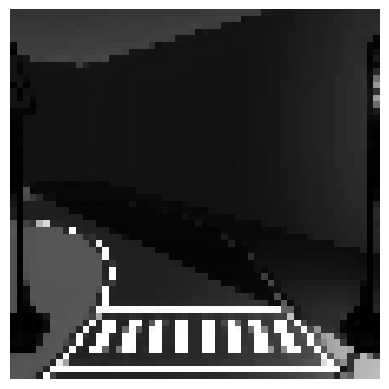

(56, 56, 1)


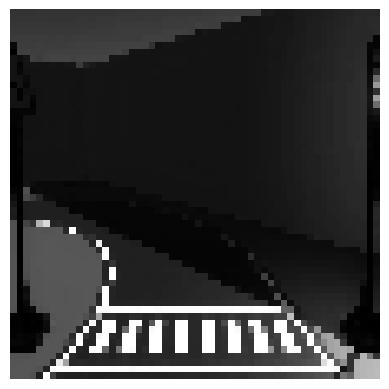

(56, 56, 1)


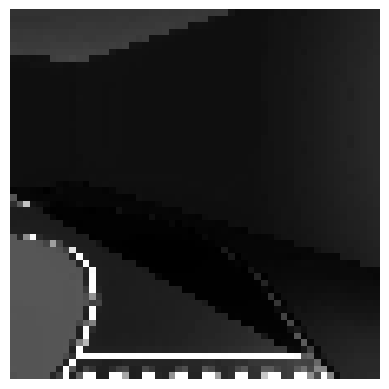

(56, 56, 1)


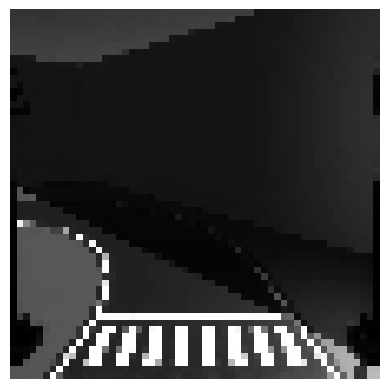

(56, 56, 1)


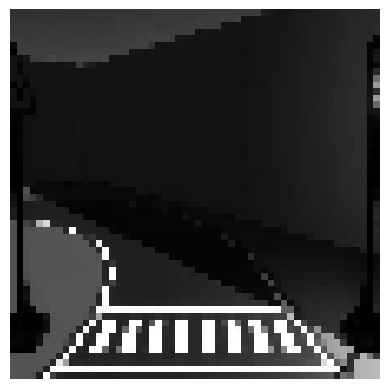

In [36]:
for image in dataset.take(5):
    image_np = image.numpy() # convert to a NumPy array
    print(image.shape)
    # create a PIL Image object from the NumPy array
    # pil_image = Image.fromarray(np.uint8(image_np*255))
    # Display the image using Matplotlib
    plt.imshow(image_np, cmap='gray')
    plt.axis('off')

    # plot the image using matplotlib
    # plt.imshow(pil_image)
    plt.show()

In [50]:
# Split the dataset into training and validation sets
train_dataset = dataset.take(int(TRAIN_SPLIT * image_count))
val_dataset = dataset.take(int((1-TRAIN_SPLIT) * image_count))

(56, 56, 1)


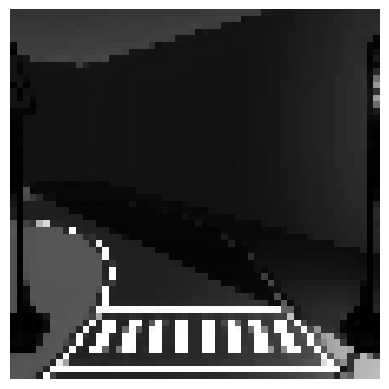

(56, 56, 1)


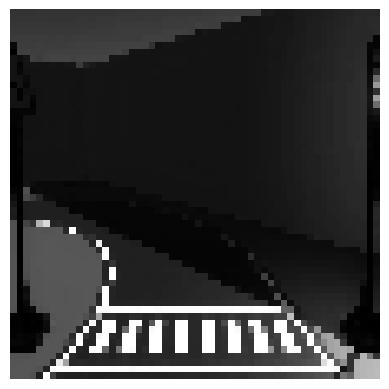

(56, 56, 1)


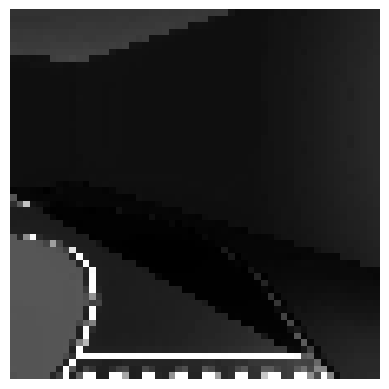

(56, 56, 1)


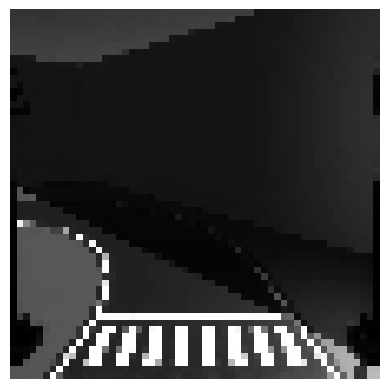

(56, 56, 1)


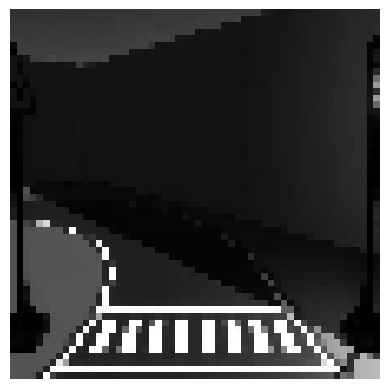

In [38]:
for image in train_dataset.take(5):
    image_np = image.numpy() # convert to a NumPy array
    print(image.shape)
    # create a PIL Image object from the NumPy array
    # pil_image = Image.fromarray(np.uint8(image_np*255))
    # Display the image using Matplotlib
    plt.imshow(image_np, cmap='gray')
    plt.axis('off')

    # plot the image using matplotlib
    # plt.imshow(pil_image)
    plt.show()

In [64]:
# Split the dataset into training and validation sets
train_dataset = dataset.take(int(TRAIN_SPLIT * image_count))
val_dataset = dataset.take(int((1-TRAIN_SPLIT) * image_count))
# train_dataset = train_dataset.shuffle(buffer_size=500, seed=42)
train_dataset = train_dataset.shuffle(buffer_size=500, seed=42)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

val_dataset = val_dataset.shuffle(buffer_size=500, seed=42)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

128 -1 (44, 56, 56, 1)


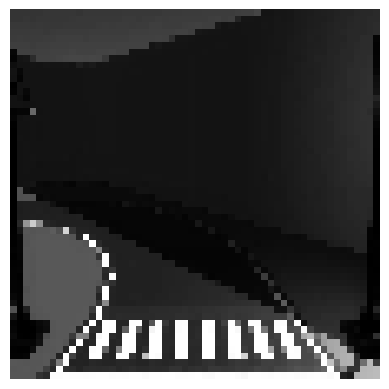

In [66]:
for image in train_dataset.take(5):
    image_np = image.numpy() # convert to a NumPy array
    print(BATCH_SIZE, AUTOTUNE, image.shape)
    # create a PIL Image object from the NumPy array
    # pil_image = Image.fromarray(np.uint8(image_np*255))
    # Display the image using Matplotlib
    plt.imshow(image_np[0], cmap='gray')
    plt.axis('off')

    # plot the image using matplotlib
    # plt.imshow(pil_image)
    plt.show()

In [67]:
encoder, encoder_layers_dim = encoder_model(input_shape = INPUT_SHAPE, filters=FILTERS, dense_layer_dim=DENSE_LAYER_DIM, latent_dim=LATENT_DIM)
decoder = decoder_model(encoder_layers_dim)
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [68]:
class VAECallbackv2(tf.keras.callbacks.Callback):
    def __init__(self, vae, test_dataset, n=10):
        self.vae = vae
        self.test_dataset = test_dataset
        self.n = n
    def on_epoch_end(self, epoch, logs=None):
        # Generate decoded images from the test input
        test_batch = next(iter(self.test_dataset))
        # print(test_batch.shape)
        _, _, _, reconstructed_images = self.vae.predict(test_batch)
        # print(reconstructed_images.shape)
        # Rescale pixel values to [0, 1]
        # reconstructed_images = reconstructed_images
        reconstructed_images = np.clip(reconstructed_images, 0.0, 1.0)

        # Plot the original and reconstructed images side by side
        plt.figure(figsize=(10, 20))
        for i in range(self.n):
            plt.subplot(10, 2, 2*i+1)
            plt.imshow(test_batch[i], cmap='gray')
            plt.axis('off')
            plt.subplot(10, 2, 2*i+2)
            plt.imshow(reconstructed_images[i], cmap='gray')
            plt.axis('off')
        plt.savefig('decoded_images_epoch_{:04d}.png'.format(epoch))
        plt.show()

Epoch 1/300
1/1 [==============================] - 1s 627ms/step - loss: 2169.4536 - reconstruction_loss: 2169.4429 - kl_loss: 0.0106


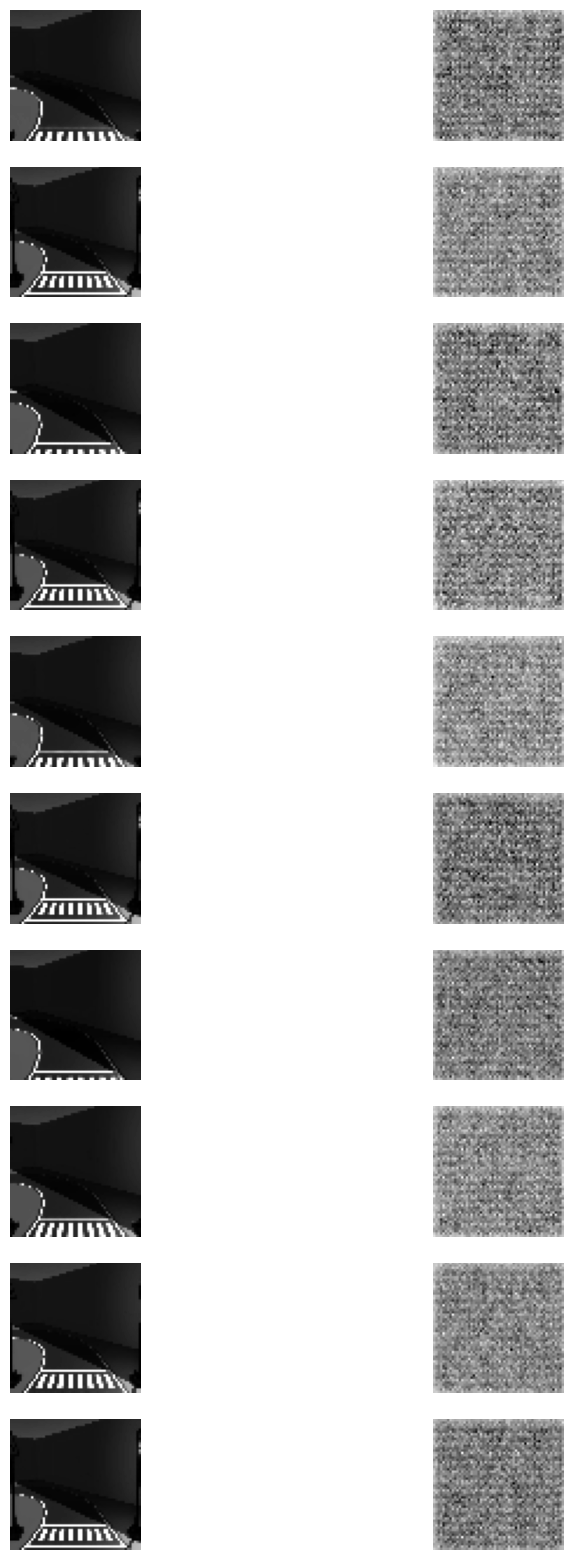

Epoch 2/300
1/1 [==============================] - 0s 193ms/step - loss: 2156.8303 - reconstruction_loss: 2156.7368 - kl_loss: 0.0935


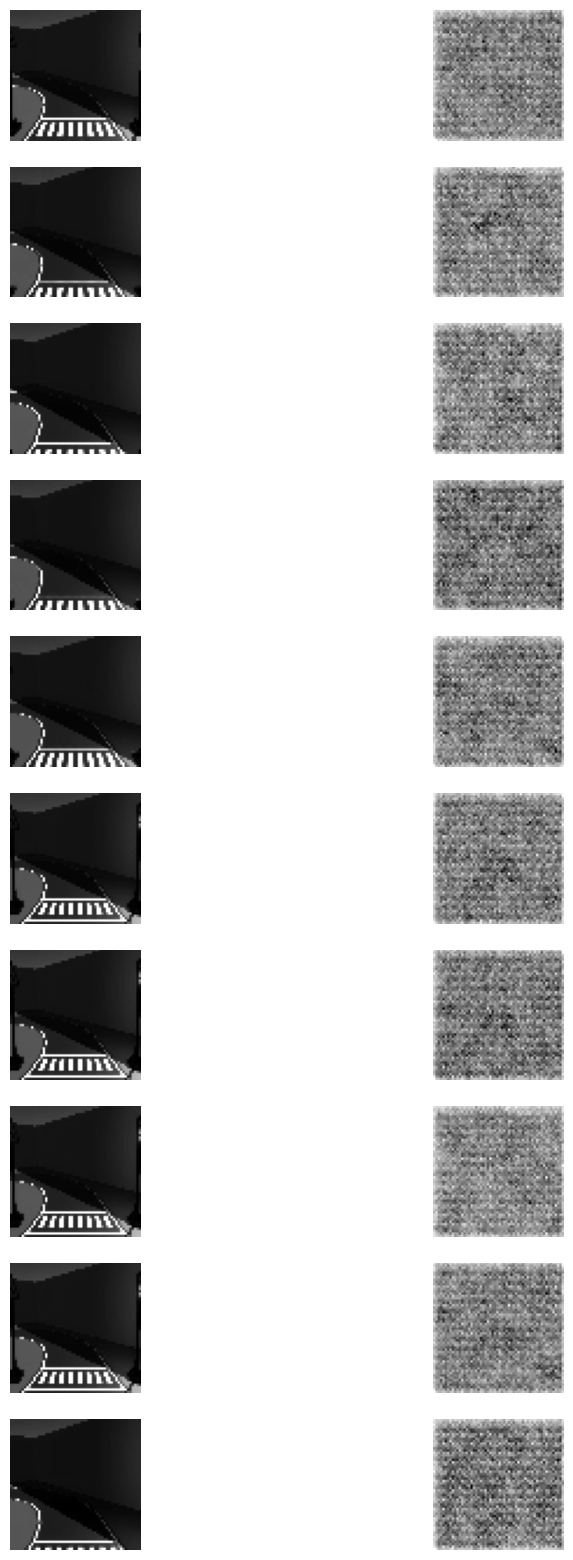

Epoch 3/300
1/1 [==============================] - 0s 191ms/step - loss: 2140.9280 - reconstruction_loss: 2140.4919 - kl_loss: 0.4360


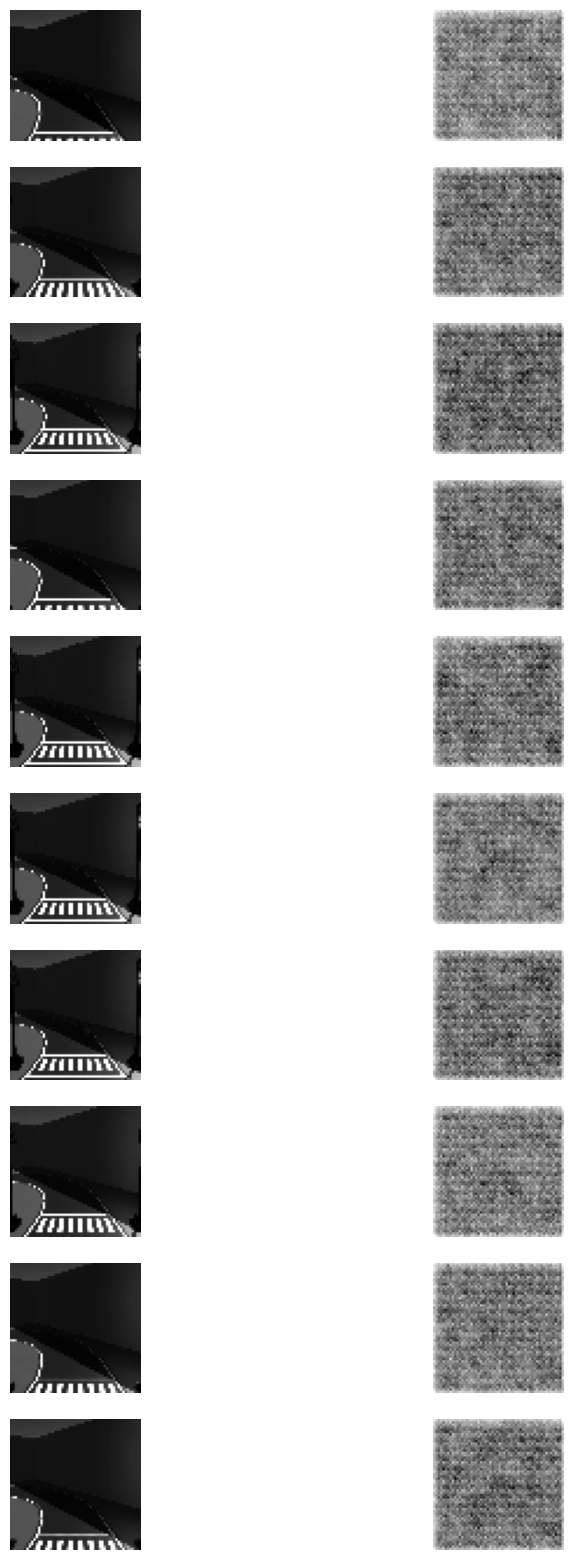

Epoch 4/300
1/1 [==============================] - 0s 195ms/step - loss: 2119.6099 - reconstruction_loss: 2118.2715 - kl_loss: 1.3384


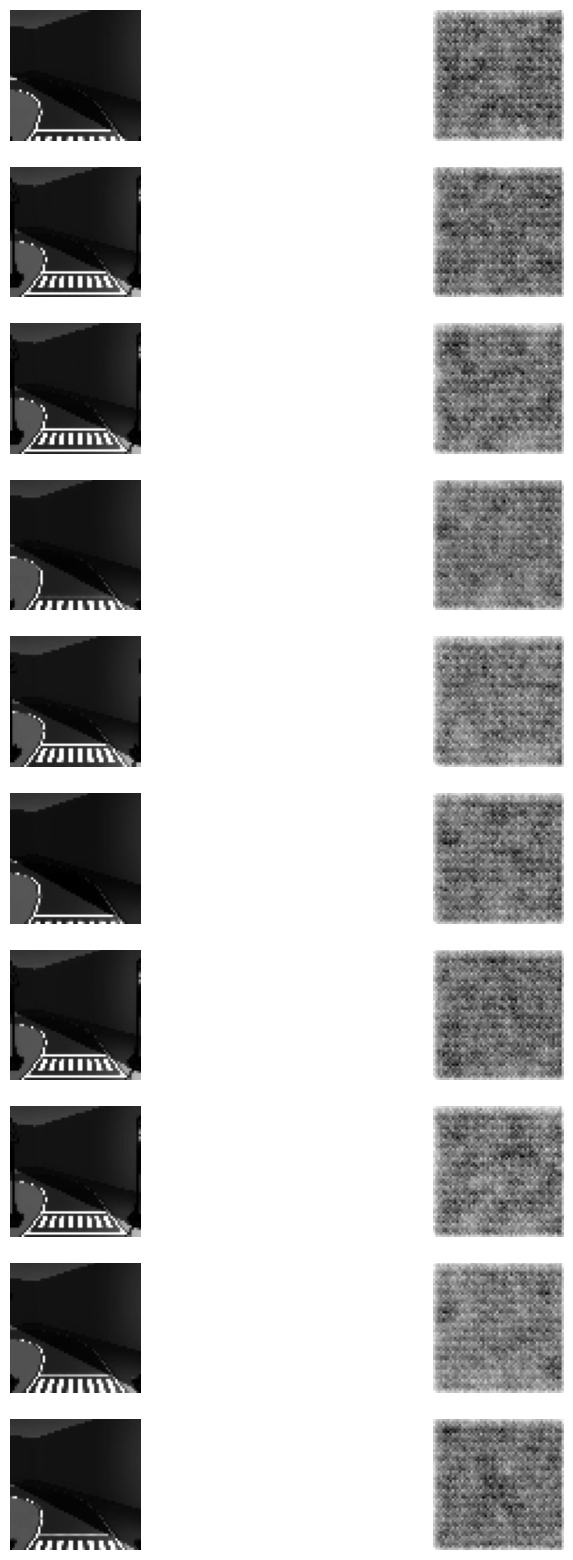

Epoch 5/300
1/1 [==============================] - 0s 192ms/step - loss: 2089.7869 - reconstruction_loss: 2086.4565 - kl_loss: 3.3302


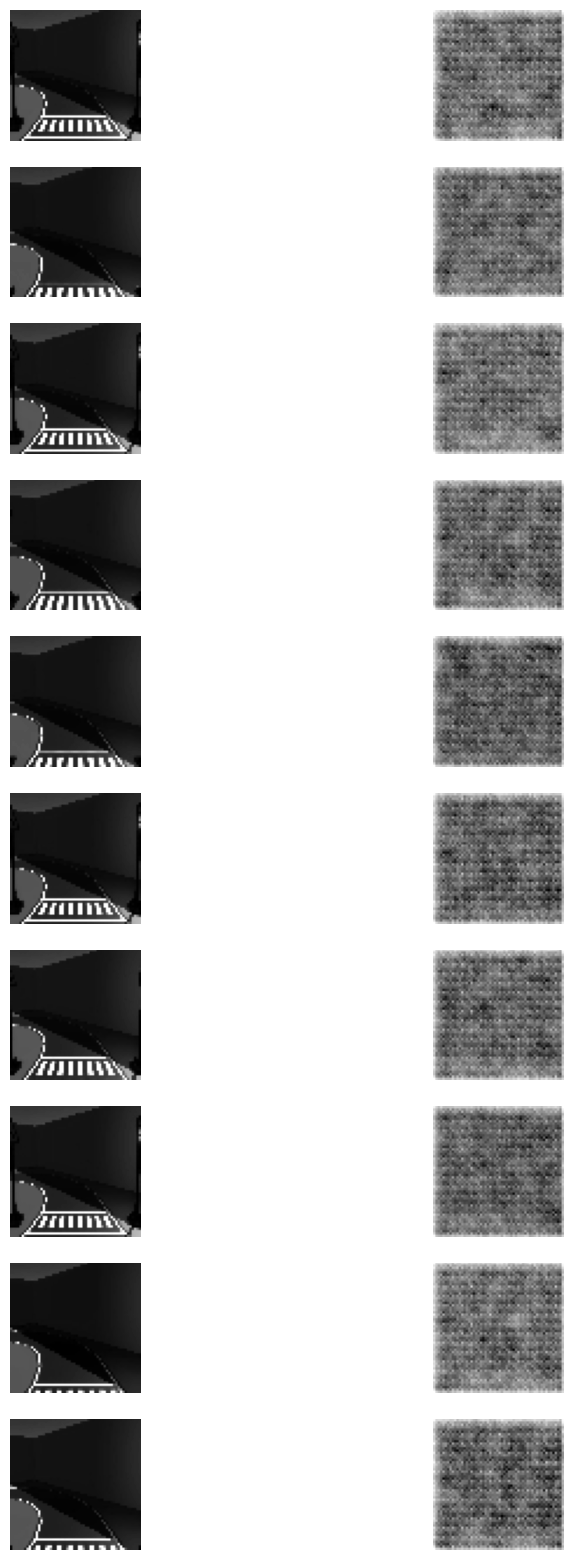

Epoch 6/300
1/1 [==============================] - 0s 196ms/step - loss: 2031.5731 - reconstruction_loss: 2024.0568 - kl_loss: 7.5163


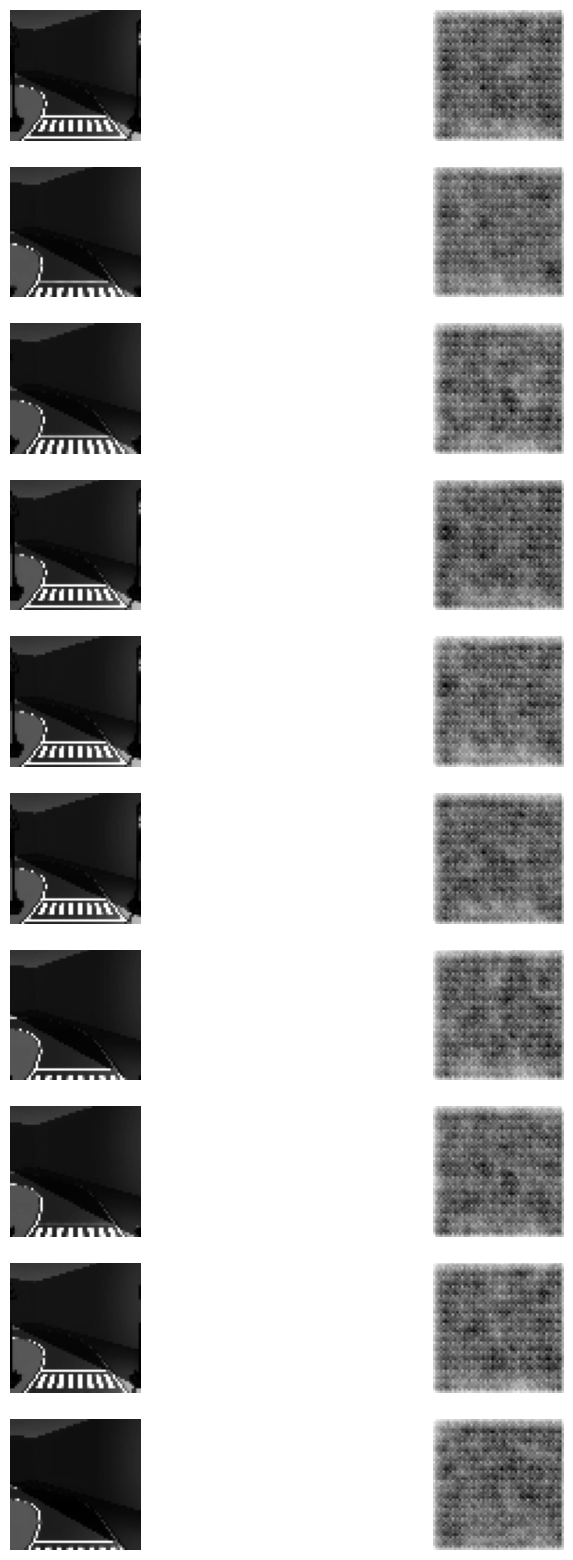

Epoch 7/300
1/1 [==============================] - 0s 206ms/step - loss: 1964.4600 - reconstruction_loss: 1948.4524 - kl_loss: 16.0076


KeyboardInterrupt: 

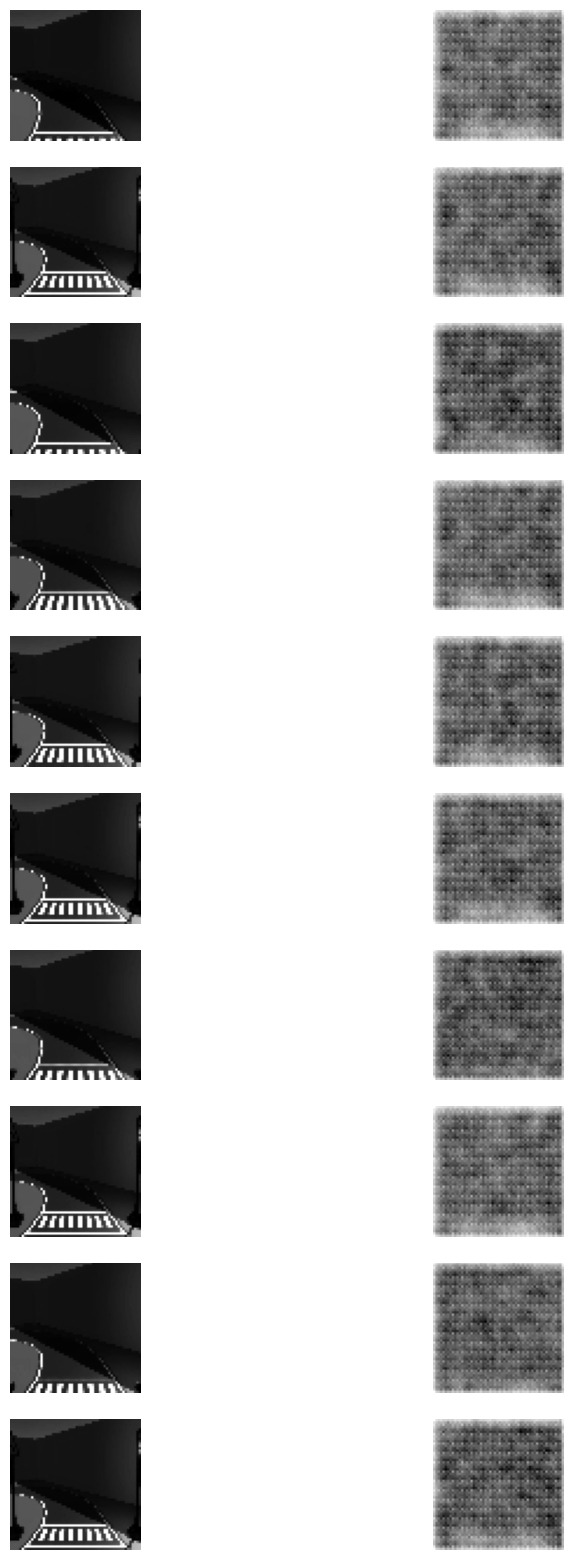

In [69]:
vae_callback = VAECallbackv2(vae, val_dataset)

history = vae.fit(train_dataset, epochs=300, callbacks=[vae_callback])
